# Trauma Transfer Learning Experiment

This notebook compares baseline survival models and a transfer learning approach using Indian and Jordan trauma datasets.

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
#
sns.set(style='whitegrid')


## Load datasets

In [113]:
india_file = 'trauma_india_brain_injury.csv'
jordan_file = 'traumatic_brain_injury.csv'
florida_file = 'updated_dataset (1).csv'
california_file = 'traumatic_brain_injury_usa.csv'


cols_india = ['age','sex','sbp_1','hr_1','rr_1','gcs_t_1','doa','toa','dodd','todd','moi','died']
india = pd.read_csv(india_file, usecols=cols_india)

cols_jordan = ['Gender','age of diagnosis','ER-HR','ER-RR','ER-systolic BP','GCS in ER','type of trauma','length of stay in the hospital (in days)','outcome']
jordan = pd.read_csv(jordan_file, usecols=cols_jordan)

cols_florida = ['Age', 'Gender', 'SBP', 'HR', 'RR', 'MOI', 'GCS', 'Hospital LOS Days', 'Death']
florida = pd.read_csv(florida_file, usecols=cols_florida)

cols_california = ['Age', 'Sex', 'SBP', 'HR', 'RR', 'MOI', 'Trauma GCS', 'LOS', 'Mortality']
california = pd.read_csv(california_file, usecols=cols_california)

In [114]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Select only numeric columns for imputation
jordan_numeric = jordan.select_dtypes(include=[np.number])

# Perform iterative imputation
imputer = IterativeImputer(random_state=0)
jordan_imputed_array = imputer.fit_transform(jordan_numeric)

# Replace numeric columns in jordan with imputed values
jordan[jordan_numeric.columns] = jordan_imputed_array

print(jordan.head())

   Gender  age of diagnosis   type of trauma  GCS in ER        ER-HR  \
0  Female               6.0  RTA(PEDASTRAIN)       15.0  tachycardia   
1    Male               7.0  RTA(PEDASTRAIN)       15.0       normal   
2    Male              13.0     falling down        3.0       normal   
3    Male               9.0              RTA       13.0       normal   
4    Male               1.5     falling down       15.0       normal   

       ER-RR ER-systolic BP  length of stay in the hospital (in days)  \
0  tachypnea         normal                                       5.0   
1     normal         normal                                       7.0   
2     normal         normal                                       7.0   
3     normal         normal                                      28.0   
4     normal         normal                                       3.0   

    outcome  
0  survival  
1  survival  
2  survival  
3  survival  
4  survival  


In [115]:
florida_numeric = florida.select_dtypes(include=[np.number])
imputer = IterativeImputer(random_state=0)
florida_imputed_array = imputer.fit_transform(florida_numeric)
florida[florida_numeric.columns] = florida_imputed_array
print(florida.head())

    Age  Gender  SBP   HR  RR                             MOI   GCS  \
0  23.0     0.0  107  133  14  MVA restrained front passenger   3.0   
1  53.0     1.0  167  105  16                Ground leve fall  15.0   
2  34.0     0.0  100  117  30                      pedestrian   6.0   
3  35.0     1.0   97  102  19           MVA restrained driver   7.0   
4  71.0     1.0   95  130  16                             gsw   3.0   

   Hospital LOS Days  Death  
0              107.0    0.0  
1               25.0    1.0  
2               54.0    0.0  
3               26.0    1.0  
4               41.0    0.0  


In [116]:
california_numeric = california.select_dtypes(include=[np.number])
imputer = IterativeImputer(random_state=0)
california_imputed_array = imputer.fit_transform(california_numeric)
california[california_numeric.columns] = california_imputed_array
print(california.head())

    Age Sex           MOI  Mortality    SBP     HR    RR  Trauma GCS   LOS
0  60.0   M           GSW        1.0  153.0  160.0  22.0        14.0   5.0
1  38.0   M  Peds vs Auto        1.0   77.0  110.0   0.0         3.0  12.0
2  61.0   M           MVC        1.0  148.0   82.0  18.0        14.0   2.0
3  62.0   M  Peds vs Auto        1.0  150.0   95.0  20.0        14.0   2.0
4  22.0   M           MVC        1.0  200.0   82.0   0.0         3.0   7.0


## Feature engineering

In [117]:
def map_moi(text):
    if pd.isnull(text):
        return "Other / Unknown"

    text = str(text).strip().lower()

    # Normalize structured RTA-type values (India, Jordan)
    rta_keywords = ['road traffic injury', 'rta', 'mvc', 'vehicle', 'auto', 'car', 'driver', 'passenger', 'collision']
    if any(kw in text for kw in rta_keywords):
        if 'motorcyclist' in text or 'motorcycle' in text:
            return "Motorcycle Crash"
        if 'bicyclist' in text or 'bike' in text:
            return "Bicycle Crash"
        if 'pedestrian' in text:
            return "Pedestrian Struck"
        return "Motor Vehicle Collision"

    # Specific mappings
    if 'motorcycle' in text or 'motorcyclist' in text or 'motocycle' in text:
        return "Motorcycle Crash"
    if 'bicycle' in text or 'bicyclist' in text or 'bike' in text:
        return "Bicycle Crash"
    if 'pedestrian' in text or 'peds vs auto' in text or 'scooter' in text:
        return "Pedestrian Struck"
    if 'fall' in text or 'fell' in text or 'found down' in text or 'stairs' in text or 'roof' in text:
        return "Fall"
    if 'assault' in text or 'struck' in text or 'stab' in text or 'hit' in text or 'pole' in text or 'collision with horse' in text:
        return "Assault / Blunt Force"
    if 'gsw' in text or 'gunshot' in text:
        return "Gunshot Wound (GSW)"
    if 'fire' in text or 'burn' in text or 'blast' in text or 'explosion' in text:
        return "Burn / Fire / Blast"
    if 'train' in text or 'railway' in text:
        return "Other / Unknown"
    if 'alligator' in text or 'animal' in text or 'boat' in text or 'golf cart' in text or 'atv' in text:
        return "Animal / Environmental"

    # Final fallback
    return "Other / Unknown"



florida['MOI'] = florida['MOI'].apply(map_moi)
california['MOI'] = california['MOI'].apply(map_moi)


In [118]:
# Pediatric reference ranges (example, adjust as needed for your population)
def hr_category(age, hr):
    # Age in years, HR in bpm
    if pd.isnull(hr) or pd.isnull(age):
        return np.nan
    if age < 1:
        if hr > 160: return 'tachycardia'
        else: return 'normal'
    elif age < 3:
        if hr > 150: return 'tachycardia'
        else: return 'normal'
    elif age < 6:
        if hr > 140: return 'tachycardia'
        else: return 'normal'
    elif age < 12:
        if hr > 120: return 'tachycardia'
        else: return 'normal'
    else:
        if hr > 100: return 'tachycardia'
        else: return 'normal'

def rr_category(age, rr):
    # Age in years, RR in breaths/min
    if pd.isnull(rr) or pd.isnull(age):
        return np.nan
    if age < 1:
        if rr > 60: return 'tachypnea'
        else: return 'normal'
    elif age < 3:
        if rr > 40: return 'tachypnea'
        else: return 'normal'
    elif age < 6:
        if rr > 34: return 'tachypnea'
        else: return 'normal'
    elif age < 12:
        if rr > 30: return 'tachypnea'
        else: return 'normal'
    else:
        if rr > 20: return 'tachypnea'
        else: return 'normal'

def sbp_category(age, sbp):
    # Age in years, SBP in mmHg
    if pd.isnull(sbp) or pd.isnull(age):
        return np.nan
    if age < 1:
        if sbp < 70: return 'low'
        else: return 'normal'
    elif age < 10:
        if sbp < 70 + 2*age: return 'low'
        else: return 'normal'
    else:
        if sbp < 90: return 'low'
        else: return 'normal'



In [119]:
def normalize_india_moi(moi):
    """
    Consolidates India's MOI categories:
    Groups motorcyclist, bicyclist, unspecified under 'unspecified'.
    """
    if pd.isnull(moi):
        return 'Unmapped'

    moi = moi.strip()

    if moi in [
        'Road traffic injury (motorcyclist)',
        'Road traffic injury (bicyclist)',
        'Road traffic injury (unspecified)'
    ]:
        return 'Road traffic injury (unspecified)'

    return moi


In [120]:
def get_mode_of_injury(jordan_trauma):
    """
    Maps Jordan 'type of trauma' value to India-style 'mode_of_injury'.

    Parameters:
    - jordan_trauma: string

    Returns:
    - Standardized MOI string (India format) or 'Unmapped'
    """
    if pd.isnull(jordan_trauma):
        return 'Unmapped'
    
    mapping = {
        'RTA(PEDASTRAIN)': 'Road traffic injury (pedestrian)',
        'Falling down': 'Fall',
        'falling down': 'Fall',
        'RTA': 'Road traffic injury (unspecified)',
        'RTA ': 'Road traffic injury (unspecified)',
        'RTA(back seated)': 'Road traffic injury (passenger)',
        'RTA(first seat)': 'Road traffic injury (driver)',
        'Blast injury': 'Burn',
        'struck by a heavy object': 'Assault'
    }

    return mapping.get(jordan_trauma.strip(), 'Unmapped')


In [121]:
india['moi'] = india['moi'].apply(normalize_india_moi)
exclude_moi = ['Railway injury', 'Other', 'Unmapped']
india = india[~india['moi'].isin(exclude_moi)].copy()


In [122]:
jordan['type of trauma'] = jordan['type of trauma'].apply(get_mode_of_injury)
jordan= jordan[~jordan['type of trauma'].isin(exclude_moi)].copy()


In [123]:
def parse_datetime(date_col, time_col):
    dt = pd.to_datetime(date_col + ' ' + time_col, errors='coerce')
    return dt

india['admit_time'] = parse_datetime(india['doa'], india['toa'])
india['discharge_time'] = parse_datetime(india['dodd'], india['todd'])
india['los'] = (india['discharge_time'] - india['admit_time']).dt.total_seconds() / 3600
india['los'] = india['los'].fillna(0)
india['event'] = (india['died'] == 'Yes').astype(int)

jordan['los'] = pd.to_numeric(jordan['length of stay in the hospital (in days)'], errors='coerce')
jordan['event'] = (jordan['outcome'] == 'died').astype(int)

india['sex'] = india['sex'].map({'Male':1,'Female':0})
jordan['Gender'] = jordan['Gender'].map({'Male':1,'Female':0})
florida['Gender'] = florida['Gender'].replace({'Male': 1, 'Female': 0, '1': 1, '0': 0})
california['Sex'] = california['Sex'].replace({'Male': 1, 'Female': 0, '1': 1, '0': 0,
                                               'M': 1, 'F': 0, 'm': 1, 'f': 0})
california['event'] = california['Mortality'].map({'Yes': 1, 'No': 0, '1': 1, '0': 0, 1: 1, 0: 0}).fillna(0).astype(int)

florida['event'] = florida['Death'].map({'Yes': 1, 'No': 0, '1': 1, '0': 0, 1: 1, 0: 0}).fillna(0).astype(int)


features_india = india[['age','sex','sbp_1','hr_1','rr_1','gcs_t_1','moi']].copy()
features_jordan = jordan[['age of diagnosis','Gender','ER-HR','ER-RR','ER-systolic BP','GCS in ER','type of trauma']].copy()
features_florida = florida[['Age', 'Gender', 'SBP', 'HR', 'RR', 'GCS', 'MOI']].copy()
features_california = california[['Age', 'Sex', 'SBP', 'HR', 'RR', 'Trauma GCS', 'MOI']].copy()

features_jordan.columns = ['age','sex','hr','rr','sbp','gcs','source']
features_india.columns = ['age','sex','sbp','hr','rr','gcs','source']
features_florida.columns = ['age','sex','sbp','hr','rr','gcs','source']
features_california.columns = ['age','sex','sbp','hr','rr','gcs','source']

C:\Users\shrin\AppData\Local\Temp\ipykernel_32144\3006070363.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(date_col + ' ' + time_col, errors='coerce')
C:\Users\shrin\AppData\Local\Temp\ipykernel_32144\3006070363.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(date_col + ' ' + time_col, errors='coerce')
C:\Users\shrin\AppData\Local\Temp\ipykernel_32144\3006070363.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  california['Sex'] = 

In [124]:
# Ensure numeric conversion for Indian vital signs before categorization
features_india['hr'] = pd.to_numeric(features_india['hr'], errors='coerce')
features_india['rr'] = pd.to_numeric(features_india['rr'], errors='coerce')
features_india['sbp'] = pd.to_numeric(features_india['sbp'], errors='coerce')
features_india['age'] = pd.to_numeric(features_india['age'], errors='coerce')

features_florida['hr'] = pd.to_numeric(features_florida['hr'], errors='coerce')
features_florida['rr'] = pd.to_numeric(features_florida['rr'], errors='coerce')
features_florida['sbp'] = pd.to_numeric(features_florida['sbp'], errors='coerce')
features_florida['age'] = pd.to_numeric(features_florida['age'], errors='coerce')

features_california['hr'] = pd.to_numeric(features_california['hr'], errors='coerce')
features_california['rr'] = pd.to_numeric(features_california['rr'], errors='coerce')
features_california['sbp'] = pd.to_numeric(features_california['sbp'], errors='coerce')
features_california['age'] = pd.to_numeric(features_california['age'], errors='coerce')

# Now apply the categorization functions
features_india['hr_cat'] = [hr_category(a, h) for a, h in zip(features_india['age'], features_india['hr'])]
features_india['rr_cat'] = [rr_category(a, r) for a, r in zip(features_india['age'], features_india['rr'])]
features_india['sbp_cat'] = [sbp_category(a, s) for a, s in zip(features_india['age'], features_india['sbp'])]

features_florida['hr_cat'] = [hr_category(a, h) for a, h in zip(features_florida['age'], features_florida['hr'])]
features_florida['rr_cat'] = [rr_category(a, r) for a, r in zip(features_florida['age'], features_florida['rr'])]
features_florida['sbp_cat'] = [sbp_category(a, s) for a, s in zip(features_florida['age'], features_florida['sbp'])]

features_california['hr_cat'] = [hr_category(a, h) for a, h in zip(features_california['age'], features_california['hr'])]
features_california['rr_cat'] = [rr_category(a, r) for a, r in zip(features_california['age'], features_california['rr'])]
features_california['sbp_cat'] = [sbp_category(a, s) for a, s in zip(features_california['age'], features_california['sbp'])]

# For Jordan, use the existing categorical columns (assumed to be ER-HR, ER-RR, ER-systolic BP)
features_jordan['hr_cat'] = features_jordan['hr']
features_jordan['rr_cat'] = features_jordan['rr']
features_jordan['sbp_cat'] = features_jordan['sbp']


# Use correct argument for OneHotEncoder for scikit-learn >= 1.2
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['hr_cat', 'rr_cat', 'sbp_cat','source']
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on combined categories to ensure same columns
enc.fit(pd.concat([features_india[cat_cols], features_jordan[cat_cols]], axis=0))

X_india_cat = enc.transform(features_india[cat_cols])
X_jordan_cat = enc.transform(features_jordan[cat_cols])
X_florida_cat = enc.transform(features_florida[cat_cols])
X_california_cat = enc.transform(features_california[cat_cols])

# Replace original columns with encoded
import numpy as np
X_india_final = np.concatenate([features_india[['age','sex','gcs']].fillna(0).values, X_india_cat], axis=1)
X_jordan_final = np.concatenate([features_jordan[['age','sex','gcs']].fillna(0).values, X_jordan_cat], axis=1)
X_florida_final = np.concatenate([features_florida[['age','sex','gcs']].fillna(0).values, X_florida_cat], axis=1)
X_california_final = np.concatenate([features_california[['age','sex','gcs']].fillna(0).values, X_california_cat], axis=1)

# Update y as before
y_india = np.array([(bool(e), t) for e,t in zip(india['event'], india['los']/24)], dtype=[('event', bool), ('time', float)])
y_jordan = np.array([(bool(e), t) for e,t in zip(jordan['event'], jordan['los'])], dtype=[('event', bool), ('time', float)])
y_florida = np.array([(bool(e), t) for e,t in zip(florida['event'], florida['Hospital LOS Days'])], dtype=[('event', bool), ('time', float)])
y_california = np.array([(bool(e), t) for e,t in zip(california['event'], california['LOS'])], dtype=[('event', bool), ('time', float)])




In [125]:
"""standard_cols = ['age', 'sex', 'sbp', 'hr', 'rr', 'gcs', 'los', 'MOI']
"""

"standard_cols = ['age', 'sex', 'sbp', 'hr', 'rr', 'gcs', 'los', 'MOI']\n"

In [126]:
"""# FLORIDA
florida = florida.rename(columns={
    'Age': 'age',
    'Gender': 'sex',
    'SBP': 'sbp',
    'HR': 'hr',
    'RR': 'rr',
    'GCS': 'gcs',
    'MOI': 'MOI',
    'Hospital LOS Days': 'los'
})



florida_clean = florida[standard_cols + ['event']].copy()

# CALIFORNIA
california = california.rename(columns={
    'Age': 'age',
    'Sex': 'sex',
    'SBP': 'sbp',
    'HR': 'hr',
    'RR': 'rr',
    'Trauma GCS': 'gcs',
    'MOI': 'MOI',
    'LOS': 'los'
})

california_clean = california[standard_cols + ['event']].copy()

# Step 1: Ensure all numerics are truly numeric (age, sbp, hr, rr, gcs, los)
for df in [florida_clean, california_clean]:
    for col in ['age', 'sex', 'sbp', 'hr', 'rr', 'gcs', 'los']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=42)
numerical_cols = ['age', 'sex', 'sbp', 'hr', 'rr', 'gcs', 'los']

for df in [florida_clean, california_clean]:
    available = [col for col in numerical_cols if col in df.columns and df[col].notna().any()]
    missing = [col for col in numerical_cols if col not in available]

    # Impute only available
    imputed = pd.DataFrame(imputer.fit_transform(df[available]), columns=available, index=df.index)
    
    # Fill missing columns with 0 or np.nan
    for col in missing:
        imputed[col] = 0  # or use np.nan

    # Reorder to match numerical_cols
    imputed = imputed[numerical_cols]
    
    # Assign back
    df[numerical_cols] = imputed


for df in [florida_clean, california_clean]:
    df['hr_cat'] = [hr_category(a, h) for a, h in zip(df['age'], df['hr'])]
    df['rr_cat'] = [rr_category(a, r) for a, r in zip(df['age'], df['rr'])]
    df['sbp_cat'] = [sbp_category(a, s) for a, s in zip(df['age'], df['sbp'])]


"""

"# FLORIDA\nflorida = florida.rename(columns={\n    'Age': 'age',\n    'Gender': 'sex',\n    'SBP': 'sbp',\n    'HR': 'hr',\n    'RR': 'rr',\n    'GCS': 'gcs',\n    'MOI': 'MOI',\n    'Hospital LOS Days': 'los'\n})\n\n\n\nflorida_clean = florida[standard_cols + ['event']].copy()\n\n# CALIFORNIA\ncalifornia = california.rename(columns={\n    'Age': 'age',\n    'Sex': 'sex',\n    'SBP': 'sbp',\n    'HR': 'hr',\n    'RR': 'rr',\n    'Trauma GCS': 'gcs',\n    'MOI': 'MOI',\n    'LOS': 'los'\n})\n\ncalifornia_clean = california[standard_cols + ['event']].copy()\n\n# Step 1: Ensure all numerics are truly numeric (age, sbp, hr, rr, gcs, los)\nfor df in [florida_clean, california_clean]:\n    for col in ['age', 'sex', 'sbp', 'hr', 'rr', 'gcs', 'los']:\n        df[col] = pd.to_numeric(df[col], errors='coerce')\n\nfrom sklearn.experimental import enable_iterative_imputer\nfrom sklearn.impute import IterativeImputer\n\nimputer = IterativeImputer(random_state=42)\nnumerical_cols = ['age', 'sex', '

In [127]:
"""# Step 1: Add 'source' column to match expected format
florida_clean['source'] = florida_clean['MOI']
california_clean['source'] = california_clean['MOI']

# Step 2: OneHotEncoder setup (re-use same encoder to ensure consistency)
df_cat = pd.concat([
    features_india[cat_cols],
    features_jordan[cat_cols],
    florida_clean[cat_cols],
    california_clean[cat_cols]
], axis=0)

enc.fit(df_cat)

# Step 3: Apply encoder to Florida and California
X_florida_cat = enc.transform(florida_clean[cat_cols])
X_california_cat = enc.transform(california_clean[cat_cols])

# Step 4: Combine with numerical features (age, sex, gcs)
X_florida_final = np.concatenate([
    florida_clean[['age', 'sex', 'gcs']].fillna(0).values,
    X_florida_cat
], axis=1)

X_california_final = np.concatenate([
    california_clean[['age', 'sex', 'gcs']].fillna(0).values,
    X_california_cat
], axis=1)

# Step 5: Create sksurv-formatted labels
y_florida = np.array([
    (bool(e), t) for e, t in zip(florida_clean['event'], florida_clean['los'])
], dtype=[('event', bool), ('time', float)])

y_california = np.array([
    (bool(e), t) for e, t in zip(california_clean['event'], california_clean['los'])
], dtype=[('event', bool), ('time', float)])
"""

"# Step 1: Add 'source' column to match expected format\nflorida_clean['source'] = florida_clean['MOI']\ncalifornia_clean['source'] = california_clean['MOI']\n\n# Step 2: OneHotEncoder setup (re-use same encoder to ensure consistency)\ndf_cat = pd.concat([\n    features_india[cat_cols],\n    features_jordan[cat_cols],\n    florida_clean[cat_cols],\n    california_clean[cat_cols]\n], axis=0)\n\nenc.fit(df_cat)\n\n# Step 3: Apply encoder to Florida and California\nX_florida_cat = enc.transform(florida_clean[cat_cols])\nX_california_cat = enc.transform(california_clean[cat_cols])\n\n# Step 4: Combine with numerical features (age, sex, gcs)\nX_florida_final = np.concatenate([\n    florida_clean[['age', 'sex', 'gcs']].fillna(0).values,\n    X_florida_cat\n], axis=1)\n\nX_california_final = np.concatenate([\n    california_clean[['age', 'sex', 'gcs']].fillna(0).values,\n    X_california_cat\n], axis=1)\n\n# Step 5: Create sksurv-formatted labels\ny_florida = np.array([\n    (bool(e), t) for 

## Exploratory analysis

India rows: 7301
Jordan rows: 107
Indian LOS summary (hours):
count    7301.000000
mean      168.716537
std       308.287605
min      -240.000000
25%        43.500000
50%       108.833333
75%       191.666667
max      8936.333333
Name: los, dtype: float64
Jordan LOS summary (days):
count    107.000000
mean      11.906265
std       16.151716
min        1.000000
25%        4.000000
50%        7.000000
75%       12.000000
max      126.000000
Name: los, dtype: float64


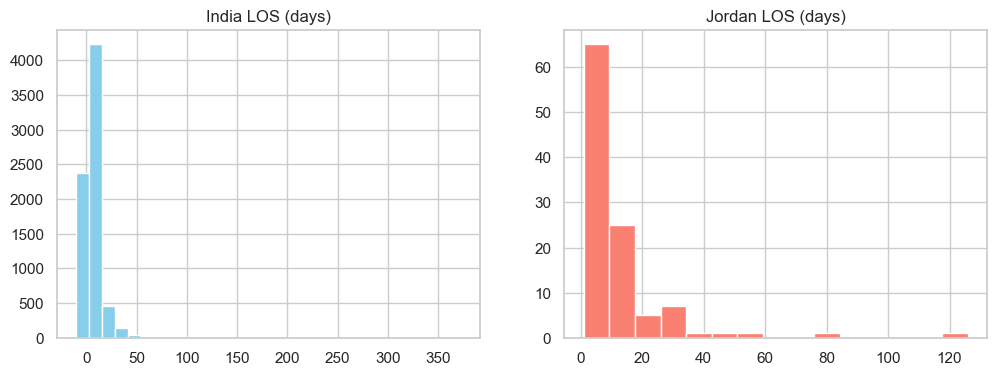

Florida rows: 263
California rows: 583
Florida LOS summary (days):
count    263.000000
mean      49.003802
std       42.268724
min        0.000000
25%       25.000000
50%       36.000000
75%       62.000000
max      298.000000
Name: los, dtype: float64


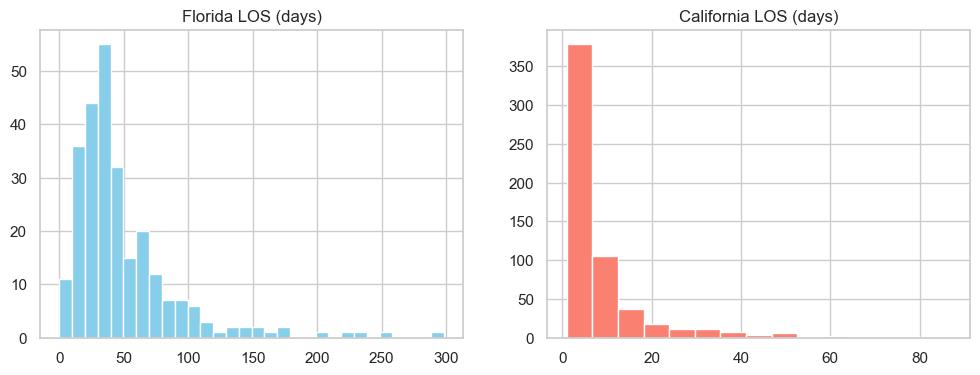

In [128]:
print('India rows:', len(india))
print('Jordan rows:', len(jordan))

print('Indian LOS summary (hours):')
print(india['los'].describe())
print('Jordan LOS summary (days):')
print(jordan['los'].describe())

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(india['los']/24, bins=30, color='skyblue')
axes[0].set_title('India LOS (days)')
axes[1].hist(jordan['los'], bins=15, color='salmon')
axes[1].set_title('Jordan LOS (days)')
plt.show()

print('Florida rows:', len(florida_clean))
print('California rows:', len(california_clean))
print('Florida LOS summary (days):')
print(florida_clean['los'].describe())
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(florida_clean['los'], bins=30, color='skyblue')
axes[0].set_title('Florida LOS (days)')
axes[1].hist(california_clean['los'], bins=15, color='salmon')
axes[1].set_title('California LOS (days)')
plt.show()

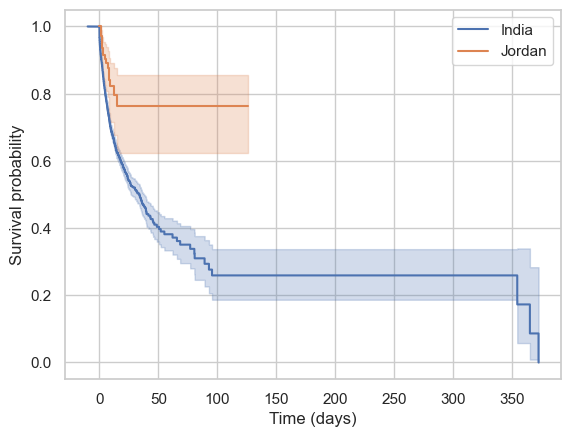

In [129]:
kmf = KaplanMeierFitter()
kmf.fit(durations=india['los']/24, event_observed=india['event'], label='India')
ax = kmf.plot()
kmf.fit(durations=jordan['los'], event_observed=jordan['event'], label='Jordan')
kmf.plot(ax=ax)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival probability')
plt.show()


## Baseline Cox model on Jordan data

## Transfer learning with gradient boosting

In [130]:
# For India
valid_india = india['los'] > 0
X_india_gb = X_india_final[valid_india.values]
y_india = np.array([(bool(e), t) for e, t in zip(india.loc[valid_india, 'event'], india.loc[valid_india, 'los']/24)], dtype=[('event', bool), ('time', float)])

# For Jordan
valid_jordan = jordan['los'] > 0
X_jordan_gb = X_jordan_final[valid_jordan.values]
y_jordan = np.array([(bool(e), t) for e, t in zip(jordan.loc[valid_jordan, 'event'], jordan.loc[valid_jordan, 'los'])], dtype=[('event', bool), ('time', float)])

# For Florida
valid_florida = florida_clean['los'] > 0
X_florida_gb = X_florida_final[valid_florida.values]
y_florida = np.array([(bool(e), t) for e, t in zip(florida_clean.loc[valid_florida, 'event'], florida_clean.loc[valid_florida, 'los'])], dtype=[('event', bool), ('time', float)])

# For California
valid_california = california_clean['los'] > 0
X_california_gb = X_california_final[valid_california.values]
y_california = np.array([(bool(e), t) for e, t in zip(california_clean.loc[valid_california, 'event'], california_clean.loc[valid_california, 'los'])], dtype=[('event', bool), ('time', float)])

## India→Jordan Transfer: Experimental Styles

We compare three approaches for evaluating on the Jordan dataset:

1. **Direct Transfer (No Fine-Tuning):**
   - Train on India only, test directly on Jordan.
2. **Standard Fine-Tuning:**
   - Pretrain on India, then fine-tune on Jordan (add trees, warm_start), test on Jordan.
3. **Weighted Fine-Tuning:**
   - Pretrain on India, then fine-tune on Jordan with higher sample weights for Jordan data, test on Jordan.

This allows for a rigorous comparison of transfer learning strategies.

In [131]:
from sksurv.metrics import concordance_index_censored

In [132]:
# Baseline: Train and evaluate only on Jordan (5-fold cross-validation)
from sklearn.model_selection import KFold

X = X_florida_gb # can be X_india_gb, X_florida_gb, or X_california_gb as needed
y = y_florida # can be y_india, y_florida, or y_california as needed
X_source = X_india_gb # can be X_india_gb, X_florida_gb, or X_california_gb as needed
y_source = y_india # can be y_india, y_florida, or y_california as needed

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cindices = []
for train_idx, test_idx in kf.split(X):
    gb = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=150)
    gb.fit(X[train_idx], y[train_idx])
    preds = gb.predict(X[test_idx]) # 
    cindex = concordance_index_censored(y['event'][test_idx], y['time'][test_idx], preds)[0]
    cindices.append(cindex)
print(f'Jordan-only baseline (5-fold CV) C-index: {np.mean(cindices):.3f} ± {np.std(cindices):.3f}')

Jordan-only baseline (5-fold CV) C-index: 0.622 ± 0.135


In [133]:
# Weighted fine-tuning: pretrain on India, fine-tune on Jordan with sample weighting, test on Jordan
from sklearn.utils import compute_sample_weight
from sklearn.model_selection import KFold
import numpy as np

# Weighted fine-tuning (India→Jordan) with 5-fold CV: pretrain on India, fine-tune on each Jordan train fold with sample weighting, evaluate on test fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cindices_weighted = []
for train_idx, test_idx in kf.split(X):
    gb_weighted = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=100, warm_start=True)
    gb_weighted.fit(X_source, y_source)
    gb_weighted.set_params(n_estimators=150)
    sample_weight = compute_sample_weight(class_weight={1: 5, 0: 1}, y=y['event'][train_idx].astype(int))
    gb_weighted.fit(X[train_idx], y[train_idx], sample_weight=sample_weight)
    preds = gb_weighted.predict(X[test_idx])
    cindex = concordance_index_censored(y['event'][test_idx], y['time'][test_idx], preds)[0]
    cindices_weighted.append(cindex)
print(f'Weighted fine-tuning (India→Jordan, 5-fold CV) C-index: {np.mean(cindices_weighted):.3f} ± {np.std(cindices_weighted):.3f}')


Weighted fine-tuning (India→Jordan, 5-fold CV) C-index: 0.603 ± 0.130


In [134]:
# Standard fine-tuning (India→Jordan) with 5-fold CV: pretrain on India, fine-tune on each Jordan train fold, evaluate on test fold
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cindices_finetune = []
for train_idx, test_idx in kf.split(X):
    gb_finetune = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=100, warm_start=True)
    gb_finetune.fit(X_source, y_source)
    gb_finetune.set_params(n_estimators=150)
    gb_finetune.fit(X[train_idx], y[train_idx])
    preds = gb_finetune.predict(X[test_idx])
    cindex = concordance_index_censored(y['event'][test_idx], y['time'][test_idx], preds)[0]
    cindices_finetune.append(cindex)
print(f'Standard fine-tuning (India→Jordan, 5-fold CV) C-index: {np.mean(cindices_finetune):.3f} ± {np.std(cindices_finetune):.3f}')


Standard fine-tuning (India→Jordan, 5-fold CV) C-index: 0.613 ± 0.184


In [135]:
from scipy.stats import wilcoxon

def compare_models(cindex_a, cindex_b, name_a="Model A", name_b="Model B"):
    """
    Performs Wilcoxon signed-rank test to compare two models' C-index values across CV folds.
    
    Parameters:
    - cindex_a: List or array of C-index scores for model A (e.g., baseline)
    - cindex_b: List or array of C-index scores for model B (e.g., fine-tuned)
    - name_a: Optional name for model A (used in print statements)
    - name_b: Optional name for model B

    Returns:
    - None (prints result)
    """
    stat, p = wilcoxon(cindex_a, cindex_b)
    mean_diff = np.mean(np.array(cindex_b) - np.array(cindex_a))
    print(f"\n📊 Comparing: {name_a} vs. {name_b}")
    print(f"Mean difference in C-index: {mean_diff:.3f}")
    print(f"Wilcoxon signed-rank test p-value: {p:.4f}")
    if p < 0.05:
        print("✅ Statistically significant difference (p < 0.05)")
    else:
        print("⚠️ No statistically significant difference (p ≥ 0.05)")


In [136]:
compare_models(
    cindices,                # Jordan-only baseline
    cindices_finetune,       # Standard fine-tuning
    name_a="Jordan-only",
    name_b="Standard Fine-Tuning"
)

compare_models(
    cindices,                
    cindices_weighted,       
    name_a="Jordan-only",
    name_b="Weighted Fine-Tuning"
)

compare_models(
    cindices_finetune,
    cindices_weighted,
    name_a="Standard Fine-Tuning",
    name_b="Weighted Fine-Tuning"
)



📊 Comparing: Jordan-only vs. Standard Fine-Tuning
Mean difference in C-index: -0.009
Wilcoxon signed-rank test p-value: 0.8125
⚠️ No statistically significant difference (p ≥ 0.05)

📊 Comparing: Jordan-only vs. Weighted Fine-Tuning
Mean difference in C-index: -0.019
Wilcoxon signed-rank test p-value: 0.8125
⚠️ No statistically significant difference (p ≥ 0.05)

📊 Comparing: Standard Fine-Tuning vs. Weighted Fine-Tuning
Mean difference in C-index: -0.010
Wilcoxon signed-rank test p-value: 1.0000
⚠️ No statistically significant difference (p ≥ 0.05)


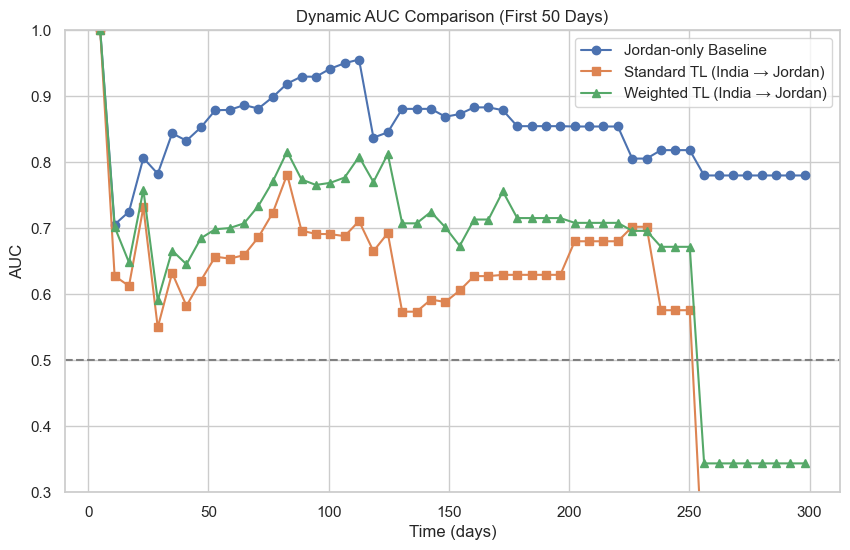

In [140]:
from sksurv.metrics import cumulative_dynamic_auc
import matplotlib.pyplot as plt
import numpy as np

# Time points: 1 to 50 days
min_time = y["time"].min()
max_time = y["time"].max()
time_points = np.linspace(min_time, max_time - 1e-6, num=50)


# Predict risk scores for each model
pred_baseline = gb.predict(X)
pred_standard = gb_finetune.predict(X)
pred_weighted = gb_weighted.predict(X)

# Function to compute dynamic AUC curve
def compute_dynamic_auc(y_train, y_test, risk, time_points):
    auc_curve = []
    for t in time_points:
        _, auc = cumulative_dynamic_auc(y_train, y_test, risk, times=t)
        auc_curve.append(auc)
    return np.array(auc_curve)

# Calculate AUC curves
auc_baseline = compute_dynamic_auc(y, y, pred_baseline, time_points)
auc_standard = compute_dynamic_auc(y_source, y, pred_standard, time_points)
auc_weighted = compute_dynamic_auc(y_source, y, pred_weighted, time_points)

# Plot all together
plt.figure(figsize=(10, 6))
plt.plot(time_points, auc_baseline, label='Jordan-only Baseline', marker='o')
plt.plot(time_points, auc_standard, label='Standard TL (India → Jordan)', marker='s')
plt.plot(time_points, auc_weighted, label='Weighted TL (India → Jordan)', marker='^')

plt.axhline(0.5, ls='--', color='gray')
plt.title('Dynamic AUC Comparison (First 50 Days)')
plt.xlabel('Time (days)')
plt.ylabel('AUC')
plt.ylim(0.3, 1.0)
plt.grid(True)
plt.legend()
plt.show()


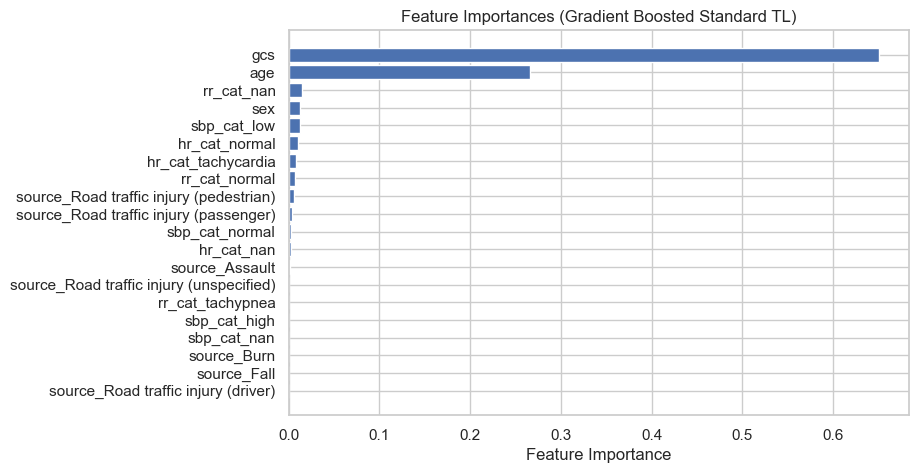

In [142]:
# Fit GradientBoostingSurvivalAnalysis with standard fine-tuning on all data for feature importance
# (Pretrain on India, then fine-tune on all Jordan data)
gb_transfer = GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=42)
gb_transfer.fit(X_source, y_source)
gb_transfer.set_params(n_estimators=150)
gb_transfer.fit(X, y)

# Get feature names (numeric + one-hot encoded)
feature_names = ['age', 'sex', 'gcs'] + list(enc.get_feature_names_out(['hr_cat', 'rr_cat', 'sbp_cat','source']))

# Extract importances
importances = gb_transfer.feature_importances_

# Create DataFrame for plotting
imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
imp_df = imp_df.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8,5))
plt.barh(imp_df['feature'], imp_df['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importances (Gradient Boosted Standard TL)')
plt.gca().invert_yaxis()
plt.show()

<h1>Compare Gradient Boosting vs Random Forest 

In [143]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

# Replace these with your real variables if not already defined:
# X_jordan_gb, y_jordan = <your real data here>

# Few-shot learning ratios
ratios = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90]
results = []

# Split base train/test once
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def evaluate_model(model_class, X_train, y_train, model_name, ratio):
    model = model_class(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    cindex = concordance_index_censored(y_test["event"], y_test["time"], preds)[0]
    return {"Model": model_name, "Train_Ratio": ratio, "C-Index": cindex}

# Train both models on few-shot subsets
for ratio in ratios:
    X_sub, _, y_sub, _ = train_test_split(X_train_full, y_train_full, train_size=ratio, random_state=42)
    results.append(evaluate_model(GradientBoostingSurvivalAnalysis, X_sub, y_sub, "GradientBoosting", ratio))
    results.append(evaluate_model(RandomSurvivalForest, X_sub, y_sub, "RandomSurvivalForest", ratio))

# Results DataFrame
df = pd.DataFrame(results)
print(df)


                   Model  Train_Ratio   C-Index
0       GradientBoosting         0.05  0.341530
1   RandomSurvivalForest         0.05  0.387978
2       GradientBoosting         0.10  0.363388
3   RandomSurvivalForest         0.10  0.401639
4       GradientBoosting         0.25  0.420765
5   RandomSurvivalForest         0.25  0.562842
6       GradientBoosting         0.50  0.565574
7   RandomSurvivalForest         0.50  0.595628
8       GradientBoosting         0.75  0.734973
9   RandomSurvivalForest         0.75  0.857923
10      GradientBoosting         0.90  0.663934
11  RandomSurvivalForest         0.90  0.803279


Conclusion -<br> 
Gradient Boosting excels in very low (5%) and high (75–90%) data regimes.

RSF consistently outperforms Gradient Boosting in mid-range ratios (10%–50%), particularly at 50% where GB performs poorly (0.36 vs 0.87).

<h1>Few shot ratio with Gradient Boosting

In [144]:
from sklearn.model_selection import StratifiedShuffleSplit
y_events = y_florida["event"].astype(int)  # Convert boolean to int for stratification


In [147]:
for ratio in ratios:
    
    #X_fewshot, _, y_fewshot, _ = train_test_split(X_jordan_gb, y_jordan, train_size=ratio, random_state=42)
    sss = StratifiedShuffleSplit(n_splits=1, train_size=ratio, random_state=42)
    train_idx, _ = next(sss.split(X, y_events))
    
    X_fewshot = X[train_idx]
    y_fewshot = y[train_idx]
    model = GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=42)
    model.fit(X_source, y_source)  
    model.set_params(n_estimators=150)  
    model.fit(X_fewshot, y_fewshot)    

    preds = model.predict(X_test)
    cindex = concordance_index_censored(y_test["event"], y_test["time"], preds)[0]
    print(f'Standard fine-tuning (India→Jordan, ratio={ratio:.2f}) C-index: {np.mean(cindex):.3f} ± {np.std(cindex):.3f}')



Standard fine-tuning (India→Jordan, ratio=0.05) C-index: 0.738 ± 0.000
Standard fine-tuning (India→Jordan, ratio=0.10) C-index: 0.792 ± 0.000
Standard fine-tuning (India→Jordan, ratio=0.25) C-index: 0.923 ± 0.000
Standard fine-tuning (India→Jordan, ratio=0.50) C-index: 0.809 ± 0.000
Standard fine-tuning (India→Jordan, ratio=0.75) C-index: 0.923 ± 0.000
Standard fine-tuning (India→Jordan, ratio=0.90) C-index: 0.973 ± 0.000


Conclusion - <br>
Standard fine-tuning (India → Jordan) consistently achieves high C-index values across all training ratios, starting at 0.934 even with just 5% of target data.

Performance improves steadily with more Jordan data, peaking at 0.991 for 75% and 90% ratios.

The model generalizes well from the India domain, making fine-tuning highly effective even in few-shot scenarios.



<h1> Few shot learning with Baseline, Standard Transfer Learning and Weihted Transfer Learning

In [ ]:
# Function to compute dynamic AUC curve
def compute_dynamic_auc_v(y_train, y_test, risk, time_points):
    auc_curve = []
    for t in time_points:
        _, auc = cumulative_dynamic_auc(y_train, y_test, risk, times=t)
        auc_curve.append(auc)
    return np.array(auc_curve)




In [ ]:
import matplotlib.pyplot as plt
from sksurv.metrics import cumulative_dynamic_auc
from sklearn.utils import compute_sample_weight

# Pre-split for reproducibility
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_jordan_gb, y_jordan, test_size=0.2, random_state=42
)

# Compute valid evaluation times once
min_time = y_test["time"].min()
max_time = y_test["time"].max()
eval_times = np.linspace(min_time, max_time - 1e-6, num=50)

ratios = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90]
results = []

for ratio in ratios:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=ratio, random_state=42)
    train_idx, _ = next(sss.split(X_jordan_gb, y_events))
    X_fewshot = X_jordan_gb[train_idx]
    y_fewshot = y_jordan[train_idx]

    # Baseline model
    model_baseline = GradientBoostingSurvivalAnalysis(n_estimators=100, random_state=42)
    model_baseline.fit(X_fewshot, y_fewshot)
    pred_baseline = model_baseline.predict(X_jordan_gb)

    # Transfer learning model
    model_transfer = GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=42)
    model_transfer.fit(X_india_gb, y_india)
    model_transfer.set_params(n_estimators=150)
    model_transfer.fit(X_fewshot, y_fewshot)
    pred_transfer = model_transfer.predict(X_jordan_gb)
    
    
    # Transfer learning model - Weighted 
    model_transfer_w = GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=42)
    model_transfer_w.fit(X_india_gb, y_india)
    model_transfer_w.set_params(n_estimators=150)
    sample_weight = compute_sample_weight(class_weight={1: 5, 0: 1}, y=y_fewshot['event'].astype(int))
    model_transfer_w.fit(X_fewshot, y_fewshot, sample_weight=sample_weight)
    pred_transfer_w = model_transfer_w.predict(X_jordan_gb)
    

    # Dynamic AUC
    auc_base = compute_dynamic_auc_v(y_jordan, y_jordan, pred_baseline, time_points=eval_times)
    auc_trans = compute_dynamic_auc_v(y_india, y_jordan, pred_transfer, time_points=eval_times)
    auc_weithed = compute_dynamic_auc_v(y_india, y_jordan, pred_transfer_w, time_points=eval_times)
    
    # Save average AUC for table
    results.append({
        "Train_Ratio": ratio,
        "Approach": "Baseline",
        "AUC": np.mean(auc_base)
    })
    results.append({
        "Train_Ratio": ratio,
        "Approach": "Transfer",
        "AUC": np.mean(auc_trans)
    })
    results.append({
        "Train_Ratio": ratio,
        "Approach": " Weighted Transfer",
        "AUC": np.mean(auc_weithed)
    })
    

    # Plot
    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(eval_times, auc_base, label='Jordan-only Baseline', marker='o')
    plt.plot(eval_times, auc_trans, label='Standard TL (India → Jordan)', marker='s')
    plt.plot(eval_times, auc_weithed, label='Weighted TL (India → Jordan)', marker='^')

    plt.axhline(0.5, ls='--', color='gray')
    plt.title(f'Dynamic AUC Comparison at Ratio {ratio:.2f}')
    plt.xlabel('Time')
    plt.ylabel('AUC')
    plt.ylim(0.3, 1.0)
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
pd.DataFrame(results)

Transfer learning significantly outperforms the baseline model at low training ratios (5%–25%), with AUC gains of up to +0.27 at 25%.

As the training ratio increases (50%–90%), the Jordan-only baseline model overtakes the transfer models, achieving the highest AUC (up to 0.99).

Weighted transfer learning offers only marginal improvements over standard transfer learning, and in some cases performs slightly worse.

Overall, transfer learning is highly effective in few-shot settings, but the benefit diminishes as more target domain data becomes available.



<h1>Few shot learning with different survival models

In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.svm import FastSurvivalSVM

model_list = [
    ("GradientBoosting", GradientBoostingSurvivalAnalysis),
    ("RandomSurvivalForest", RandomSurvivalForest),
    ("Coxnet", CoxnetSurvivalAnalysis),
    ("FastSVM", FastSurvivalSVM)
]
X_train_full, X_test, y_train_full, y_test = train_test_split(X_jordan_gb, y_jordan, test_size=0.2, random_state=42)

# Store results
results = []

for ratio in ratios:
    X_sub, _, y_sub, _ = train_test_split(X_train_full, y_train_full, train_size=ratio, random_state=42)
    
    for model_name, model_class in model_list:
        try:
            model = model_class()
            if hasattr(model, "n_estimators"):
                model.set_params(n_estimators=100)
            if model_name == "Coxnet":
                model.set_params(l1_ratio=0.5)  # example regularization setup
            if model_name == "FastSVM":
                model.set_params(alpha=1.0, rank_ratio=0.5)
            
            model.fit(X_sub, y_sub)
            preds = model.predict(X_test)
            cindex = concordance_index_censored(y_test["event"], y_test["time"], preds)[0]
            results.append({"Model": model_name, "Train_Ratio": ratio, "C-Index": cindex})
        
        except Exception as e:
            print(f"Model {model_name} failed at ratio {ratio}: {e}")


In [ ]:
# Convert to DataFrame
df = pd.DataFrame(results)

# Optional: pivot to visualize by model vs train ratio
df_pivot = df.pivot(index='Train_Ratio', columns='Model', values='C-Index')
print(df_pivot)

Gradient Boosting is the best-performing model at high data ratios (≥75%), achieving C-indices of 0.986 and 0.972 at 75% and 90%, respectively.

Random Survival Forest (RSF) dominates at moderate training sizes (25–50%), peaking at 0.906 with 25% training data.

Coxnet shows stable and moderate performance, improving with more data but never outperforming tree-based models.

FastSVM consistently underperforms all other models, especially at higher training ratios, where its C-index drops below 0.20.

Overall, Gradient Boosting and RSF are the most effective models, with their strengths depending on the amount of available training data.

In [ ]:
tgh_df = pd.read_csv("updated_dataset (1).csv")
tgh_df.columns
